In [1]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

%load_ext autoreload
%autoreload 2
%aimport connectivity

date                                 2023-11-22
h                                            22
min                                          24
s                                             6
us                                        68317
type                                      CR_BM
run                                     success
stim_block                                    3
StimNum                                     481
ChanP                                        31
ChanN                                        32
ISI_s                                  4.510225
Int_prob                                    3.0
Int_cond                                    0.0
IPI_ms                                      0.0
currentflow                               100.0
datetime       2023-11-22 22:24:06.068317+00:00
name_pos                                 OF-R-3
name_neg                                 OF-R-4
time_diff                              4.746311
TTL                                     

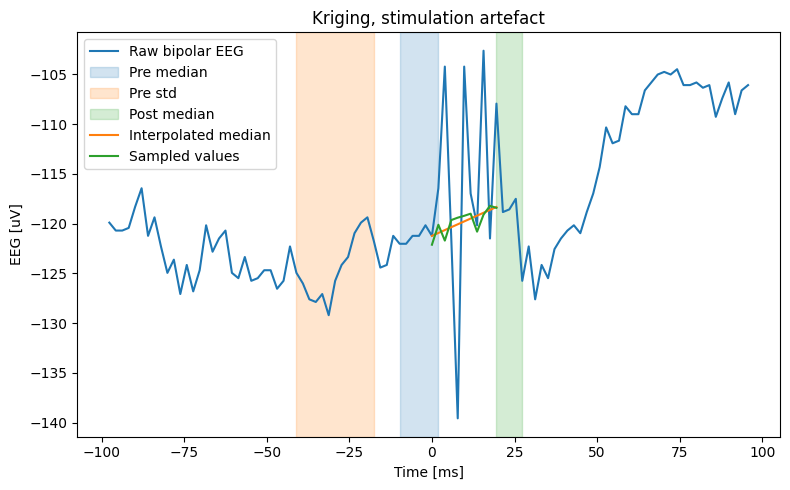

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from connectivity.load import HDFResponseLoader
from connectivity.analyze import calculate_stimulation_response_curves

name_h5 = "EL028_20231122_19h49m35_CR"

stimlist = pd.read_csv(f"D:/data/EL028/out/{name_h5}_logs.csv")[0:]

stim_id = "CR_BM-1972"
stim_index = stimlist[stimlist["stim_id"]==stim_id].index[0]
stimulation = stimlist.loc[stim_index]
print(stimulation)
channels = ["traces/raw/pH_R4", "traces/raw/pH_R5"]
print(stim_index)

rl = HDFResponseLoader(
    path_h5=f"D:/data/EL028/Electrophy/{name_h5}.h5", 
    path_logs=f"D:/data/EL028/out/{name_h5}_logs.csv",
    path_lookup="D:/data/EL028/Electrodes/Lookup.xlsx",
   )

io_stimlist = stimlist

traces = rl.get_data(
    dataset_paths=channels,
    start_row_index=stimulation["TTL"]-50,
    end_row_index=stimulation["TTL"]+50
).to_numpy()


bipolar_trace = traces[:, 0] - traces[:, 1]
window_stimulation_offset = np.round(
    np.array([0.002, 0.017]) * rl.f_sample
).astype(int)
peak_index = 51

artifact_length = np.sum(window_stimulation_offset) + 1
pre_median = np.median(
    bipolar_trace[
        peak_index
        - window_stimulation_offset[0]
        - 5 : peak_index
        - window_stimulation_offset[0]
        + 1
    ]
)
pre_std = np.std(
    bipolar_trace[
        peak_index
        - window_stimulation_offset[0]
        - artifact_length
        - 10 : peak_index
        - window_stimulation_offset[0]
        - 10
        + 1
    ]
)
post_median = np.median(
    bipolar_trace[
        peak_index
        + window_stimulation_offset[1] : peak_index
        + window_stimulation_offset[1]
        + 4
    ]
)

t = (np.arange(len(bipolar_trace)) - 50) / rl.f_sample * 1000 

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]  # Extract colors from cycle

plt.figure(figsize=(8, 5))
plt.plot(t,bipolar_trace, label="Raw bipolar EEG")
plt.axvspan(
    t[peak_index - window_stimulation_offset[0] - 5],
    t[peak_index - window_stimulation_offset[0] + 1],
    label="Pre median", alpha=0.2, color=colors[0]
)
plt.axvspan(
    t[peak_index - window_stimulation_offset[0] - artifact_length - 10],
    t[peak_index - window_stimulation_offset[0] - 10 + 1],
    label="Pre std", alpha=0.2, color=colors[1]
)
plt.axvspan(
    t[peak_index + window_stimulation_offset[1]],
    t[peak_index + window_stimulation_offset[1] + 4],
    label="Post median", alpha=0.2, color=colors[2]
)

factor = 3 
res = np.linspace(pre_median, post_median, num=artifact_length, endpoint=False)


plt.plot(
    t[
        peak_index
        - window_stimulation_offset[0] : peak_index
        + window_stimulation_offset[1]
        + 1
    ], res, label="Interpolated median"
)

res += np.random.normal(loc=0, scale=pre_std / factor, size=res.shape)

plt.plot(
    t[
        peak_index
        - window_stimulation_offset[0] : peak_index
        + window_stimulation_offset[1]
        + 1
    ], res, label="Sampled values"
)
plt.ylabel("EEG [uV]")
plt.xlabel("Time [ms]")
plt.title("Kriging, stimulation artefact")
plt.legend()
plt.tight_layout()

plt.savefig("../output/figures/sfigure3.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Accuracy

(np.float64(0.9686274509803922), np.float64(0.9882352941176471), np.float64(0.9607843137254902), np.float64(1.0))
(np.float64(0.8495963091118801), np.float64(0.9414071510957325), np.float64(0.8267589388696656), np.float64(1.0))


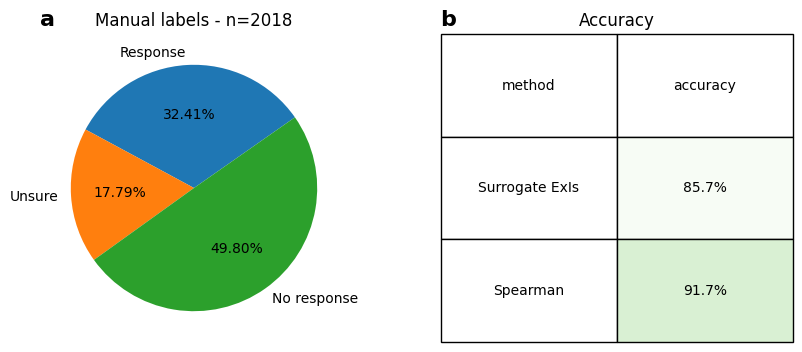

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_path = "D:/data"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean/bad_responses_dict.json"
RESPONSES_FILE = "../output/paper/significant_responses/response_channels_lf.json"
n_replications = 12

df = pd.read_json(RESPONSES_FILE)
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]
df = df[df["patient_id"].isin(allowed_ids)]


methods = ["surrogate_p_value_fdr_corrected", "spearman_p_value_fdr_corrected"]
percentiles = [0.005, 0.005]
results = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.pie(
    [len(df[df["label"] == 2]), len(df[df["label"] == 1]), len(df[df["label"] == -1])],
    labels=["Response", "Unsure", "No response"],
    #colors=["#FF9999", "#66B3FF", "#99FF99"],
    autopct="%1.2f%%",
    startangle=35,
)
ax1.set_title(f"Manual labels - n={len(df)}")

friendly_method_name = ["Surrogate ExIs", "Spearman"]
for percentile, method in zip(percentiles, methods):

    true_positives = len(df[(df["label"] == 2) & (df[method] < percentile)])
    false_positives = len(df[(df["label"] == -1) & (df[method] < percentile)])
    true_negatives = len(df[(df["label"] == -1) & (df[method] >= percentile)])
    false_negatives = len(df[(df["label"] == 2) & (df[method] >= percentile)])

    total_pop = df[(df["label"] == 2) | (df["label"] == -1)]

    results.append({
        "method": method,
        "TP": true_positives,
        "FP": false_positives,
        "TN": true_negatives,
        "FN": false_negatives,
        "accuracy": (true_negatives + true_positives) / len(total_pop)
    })


summary_df = pd.DataFrame(results)

cols_headers = ["method", "accuracy"]
summary_df = summary_df[cols_headers].values

formatted_matrix = [
    [
        (f"{value:.1%}" if j == 1 else friendly_method_name[i])
        for j, value in enumerate(row)
    ]
    for i, row in enumerate(summary_df)
]
table = ax2.table(
    cellText=formatted_matrix,  # Content
    colLabels=
       cols_headers 
    ,  # Column headers
    loc="center",
    cellLoc="center",
    bbox=[0, 0, 1, 1]  # [left, bottom, width, height] 
)
table.scale(0.5, 0.5)
table.auto_set_font_size(False)
table.set_fontsize(10)
cmap = plt.cm.Greens
min_color_val = np.nanmin(summary_df[:, 1:])
max_color_val = np.nanmax(summary_df[:, 1:]) * 1.3
# Apply colors based on value
for i in range(summary_df.shape[0]):
    for j in range(summary_df.shape[1]):
        if j > 0:
            value = summary_df[i, j]
            color = cmap((value-min_color_val)/(max_color_val-min_color_val))  # Get color from colormap
            table[i+1, j].set_facecolor(
                color
            )  # +1 because row headers exist
            print(color)

table.auto_set_column_width(
    col=2
)

ax2.axis('off')
ax2.set_title("Accuracy")

ax1.set_title("a", loc='left', fontsize=16, fontweight='bold')
ax2.set_title("b", loc='left', fontsize=16, fontweight='bold')

plt.savefig("../output/figures/sfigure2.pdf", bbox_inches='tight', dpi=300)
plt.savefig("../output/figures/sfigure2.svg", bbox_inches='tight', dpi=300)
plt.show()